# Kaggle insurance competition 2024
# Regression with an Insurance Dataset 
This notebook trains a random forest model to predict car insurance premium for a given customer. 

It is for a Kaggle competition - https://www.kaggle.com/competitions/playground-series-s4e12/overview

The tabular dataset includes insurance customer data, along with the premium each of the customers pays. 

The model's predictions were submitted to the competition and placed 818/2392 on the private leaderboard. 

In addition to entering the competition, I also explored techniques to see which features of the data are most important for making predictions, and how much these features contribute to the model's predictions - over the entire dataset or for a specific customer. _This ability to look closely at the causes of predictions is one of the strengths of tree-based models like random forests_.

Finally, a neural network was trained on the tabular dataset, and ensembled with the random forest model. This ensembled performed better than either the neural network or the random forest model alone.


![randomforest](rf.png)


In [1]:
# !pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==2.2.2

In [2]:
# imports
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import dtreeviz
from IPython.display import Image, display_svg, SVG
from pathlib import Path
import pandas as pd

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
!ls $path

insurance_competition.ipynb to.pkl
sample_submission.csv       train.csv
submission.csv              valid_xs_final.pkl
test.csv                    xs_final.pkl


In [4]:
path = Path.cwd()

In [5]:
df = pd.read_csv(path/"train.csv", low_memory=False)

In [6]:
df.head()

,id,Age,Gender,Annual Income,...,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,...,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,...,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,...,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,...,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,...,Yes,Weekly,House,2022.0


In [7]:
cols = df.columns
df.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

Find any ordinal columns which have a natural order to them, but where the ordering is not represented in the levels of the data. 

In [8]:
for col in cols:
    print(df[col].unique())

[      0       1       2 ... 1199997 1199998 1199999]
[19. 39. 23. 21. 29. 41. 48. 44. 56. 25. 40. 18. 59. 34. 22. 46. 49. 42. 43. 64. 52. 37. 58. 50. 35. 61. 31. 54. 45. 30. 33. 28. 62. 53. 47. 27. nan 38. 63. 32. 36. 20. 51. 55. 57. 24. 60. 26.]
['Female' 'Male']
[ 10049.  31678.  25602. ... 125361. 137940.  40368.]
['Married' 'Divorced' 'Single' nan]
[ 1.  3.  2.  0.  4. nan]
["Bachelor's" "Master's" 'High School' 'PhD']
['Self-Employed' nan 'Employed' 'Unemployed']
[22.59876067 15.56973099 47.17754929 ... 47.09690866 13.6616783  11.48348225]
['Urban' 'Rural' 'Suburban']
['Premium' 'Comprehensive' 'Basic']
[ 2.  1.  0. nan  3.  4.  5.  6.  7.  8.  9.]
[17. 12. 14.  0.  8.  4. 11. 10.  9.  6. 19.  3. 15. 16.  5.  7. 18.  1.  2. 13. nan]
[372. 694.  nan 367. 598. 614. 807. 398. 685. 635. 431. 597. 511. 498. 584. 420. 595. 799. 773. 798. 543. 416. 425. 486. 795. 495. 449. 803. 421. 695. 713. 589. 812. 382. 469. 530. 538. 842. 575.
 794. 836. 784. 439. 381. 801. 624. 497. 359. 662. 703.

There aren't many ordinal columns, education level might be the only one worth considering.

In [9]:
edu_levels = ('High School', "Bachelor's", "Master's", 'PhD')
df['Education Level'] = df['Education Level'].astype('category')
df["Education Level"] = df['Education Level'].cat.set_categories(edu_levels, ordered=True)

### Dependent Variable
The dependent variable is the __premium amount__ column. We'll take the Root Mean Squared Log Error (RMSLE) as the metric to evaluate the model.

In [10]:
dep_var = "Premium Amount"

### Root mean square log error
The function is available in sklearn version 1.4 and above as metrics.root_mean_squared_log_error but the fastai library imports some things from an earlier library. We can implement it manually like so:

In [11]:
def rmsle(x, y): return math.sqrt(((np.log1p(x) - np.log1p(y))**2).mean())

We're interested in the log of the premium amount.
log1p is the natural logarithm of 1 plus the input array, which is the same as sklearn's mean_squared_log_error. 
The inverse is is 
```python3
np.expm1()
```

In [12]:
df[dep_var] = np.log1p(df[dep_var])

In [13]:
df[dep_var]

0          7.962067
1          7.302496
2          6.342121
3          6.641182
4          7.612337
             ...   
1199995    7.173192
1199996    6.711740
1199997    5.918894
1199998    6.391917
1199999    7.816417
Name: Premium Amount, Length: 1200000, dtype: float64

Split the dates into various features like year, quarter, month etc. Perhaps there's a promotion that's run in a particular month that affects the premium amount. 

In [14]:
df = add_datepart(df, 'Policy Start Date')

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [15]:
df.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type',
       'Premium Amount', 'Policy Start Year', 'Policy Start Month',
       'Policy Start Week', 'Policy Start Day', 'Policy Start Dayofweek',
       'Policy Start Dayofyear', 'Policy Start Is_month_end',
       'Policy Start Is_month_start', 'Policy Start Is_quarter_end',
       'Policy Start Is_quarter_start', 'Policy Start Is_year_end',
       'Policy Start Is_year_start', 'Policy Start Elapsed'],
      dtype='object')

Process the dates in the test set too. 

In [16]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test = add_datepart(df_test, 'Policy Start Date')

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


### Handle strings and missing data. 
Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset, so this is a good starting point for data processing.

In [17]:
procs = [Categorify, FillMissing]

The samples seem to be taken from overlapping time periods, so there's no need to take the validation set from the latest entries of the training set.

In [18]:
df['Policy Start Year'].min(), df_test['Policy Start Year'].min(), df['Policy Start Year'].max(), df_test['Policy Start Year'].max()

(2019, 2019, 2024, 2024)

In [19]:
df['Policy Start Year']

0          2023
1          2023
2          2023
3          2024
4          2021
           ... 
1199995    2023
1199996    2022
1199997    2021
1199998    2021
1199999    2020
Name: Policy Start Year, Length: 1200000, dtype: int32

In [20]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont, cat

(['id',
  'Age',
  'Annual Income',
  'Number of Dependents',
  'Health Score',
  'Previous Claims',
  'Vehicle Age',
  'Credit Score',
  'Insurance Duration',
  'Policy Start Year',
  'Policy Start Month',
  'Policy Start Week',
  'Policy Start Day',
  'Policy Start Dayofweek',
  'Policy Start Dayofyear',
  'Policy Start Elapsed'],
 ['Gender',
  'Marital Status',
  'Education Level',
  'Occupation',
  'Location',
  'Policy Type',
  'Customer Feedback',
  'Smoking Status',
  'Exercise Frequency',
  'Property Type',
  'Policy Start Is_month_end',
  'Policy Start Is_month_start',
  'Policy Start Is_quarter_end',
  'Policy Start Is_quarter_start',
  'Policy Start Is_year_end',
  'Policy Start Is_year_start'])

Make a tabular pandas object

In [21]:
splits = RandomSplitter(valid_pct = 0.2)(range_of(df))
splits

((#960000) [729083,728335,909947,233536,435159,1020048,671167,490966,921659,399765...],
 (#240000) [637542,1128918,893682,648385,1100506,761290,831478,266883,499422,851477...])

In [22]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [23]:
len(to.train), len(to.valid)

(960000, 240000)

The items in the TabularPandas object are displayed with their string representation if we use show, but the underlying data is all numeric and is stored in the items attribute. 

In [24]:
to.show(3)

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Age_na,Annual Income_na,Number of Dependents_na,Health Score_na,Previous Claims_na,Vehicle Age_na,Credit Score_na,Insurance Duration_na,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Year,Policy Start Month,Policy Start Week,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Elapsed,Premium Amount
729083,Male,Married,PhD,Self-Employed,Rural,Comprehensive,Poor,No,Rarely,House,False,False,False,False,False,False,False,False,False,False,True,False,False,False,729083,23.0,11823.0,0.0,41.384293,1.0,11.0,727.0,4.0,2023,5,18,5,4,125,1.683300e+09,4.779123
728335,Male,Single,PhD,Unemployed,Rural,Basic,Poor,Yes,Rarely,House,False,False,False,False,False,False,False,False,False,False,False,False,True,False,728335,45.0,6655.0,0.0,23.327639,3.0,18.0,595.0,7.0,2020,5,21,18,0,139,1.589815e+09,7.395721
909947,Male,Single,PhD,Employed,Suburban,Comprehensive,Poor,No,Daily,Apartment,True,False,False,False,False,False,False,False,False,False,False,False,False,False,909947,31.0,12645.0,0.0,21.060629,0.0,14.0,817.0,2.0,2023,4,17,30,6,120,1.682868e+09,6.001415


In [25]:
to.items.head(3)

,id,Age,Gender,Annual Income,...,Previous Claims_na,Vehicle Age_na,Credit Score_na,Insurance Duration_na
729083,729083,23.0,2,11823.0,...,2,1,1,1
728335,728335,45.0,2,6655.0,...,1,1,2,1
909947,909947,31.0,2,12645.0,...,1,1,1,1


In [26]:
to.classes['Education Level']

['#na#', 'High School', "Bachelor's", "Master's", 'PhD']

The ordering of the categories was preserved.

## Checkpoint

In [27]:
save_pickle(path/'to.pkl', to)

In [28]:
to = load_pickle(path/'to.pkl')

# Train a decision tree model
Define the dependent and independent variables.

In [29]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that all the data is numeric and there are no missing values, we can train a decision tree model.

In [30]:
m = DecisionTreeRegressor(max_leaf_nodes=9)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=9)

Take a sample 500 from the training set so that we don't have a huge plot

[]

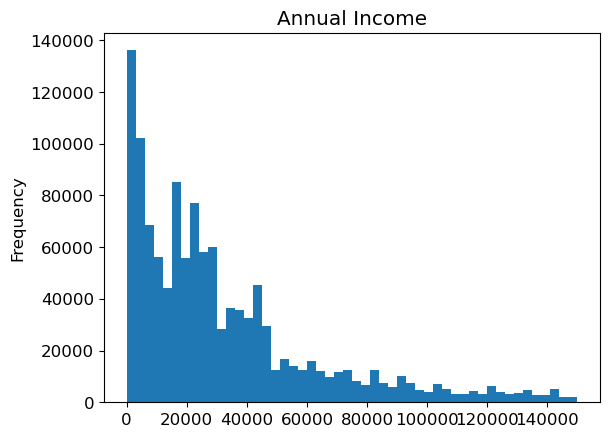

In [31]:
to.items['Annual Income'].plot.hist(title='Annual Income', bins=50).plot()

## Visualizing the data splits made by the initial decision tree

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


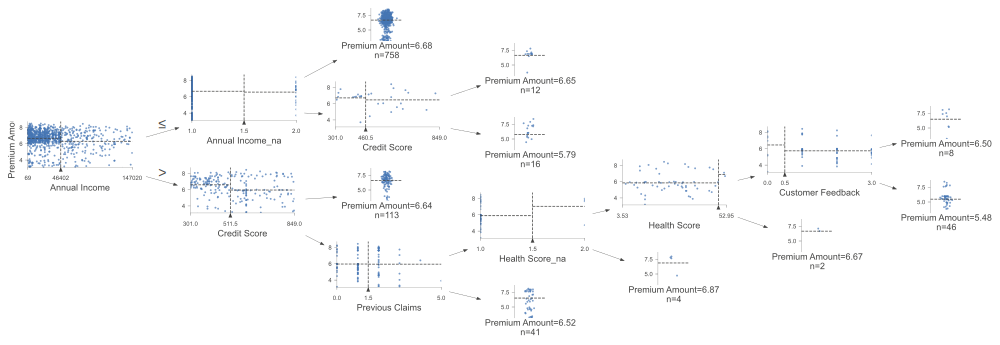

In [32]:
sample_idx = np.random.permutation(len(y))[:1000]
viz_rmodel = dtreeviz.model(model=m, X_train=xs.iloc[sample_idx], y_train=y.iloc[sample_idx], feature_names=xs.columns, target_name=dep_var)
viz_rmodel.view(orientation='LR')

The ordering of boolean columns such as Age_na for whether the age column was missing is preserved, with False=1 and True=2

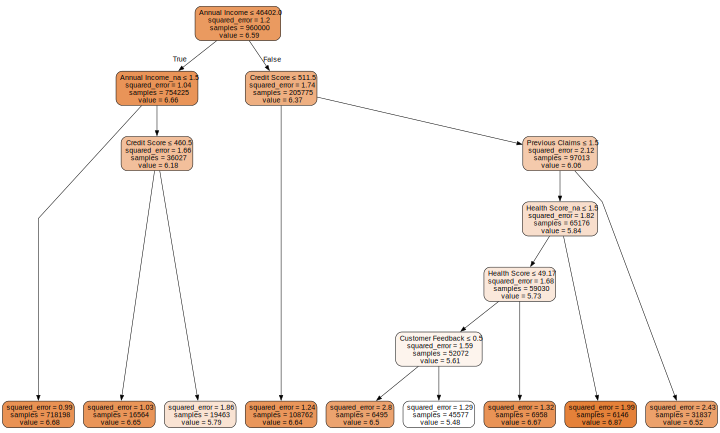

In [33]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

The decision tree is making some splits which result in groups with a larger error in one group and a smaller error in the other group. The group with the smaller error is always the largest of the two groups. This is probably ok, since the model is trying to find the split which gives the largest overall reduction in the squared error across the two groups.

The previous examples i've worked on though, had splits which reduced the error in both groups - so pay attention to this when interpreting the results. 
At the end of the decision tree, the average of the weighted errors in the leaf nodes needs to be less than the average of the errors in the parent node, otherwise the model is worse than just predicting the mean. 

## Initial observations
Annual income is a strong predictor of premium amount the group earning under 46k has a higher premium amount than the group earning over 46k. For the group earning over 46k, the prediction of premium price for the average of this group is worse than the mean prediction for the entire dataset, but the group only contains 205775 samples compared with 754225 in the group earning under 46k where the prediction for the mean of the group is better than the mean prediction for the entire dataset. 

For the group earning under 46k, the next most infomative split is whether their income amount is provided or not. For those where the income amount isn't provided, the next most informative split is credit score. For those with income amount provided (as some amount below 46k) this ends in a leaf node where the squared error for the group of 720,000 people is 1.0 compared with 1.21 at the parent node. Further splits in the tree will lead to finer categories, potentially some splits for this lower income group will to a further reduction in the error.

Other interesting splits are:
- If the number of previous claims is 2 or more, the premium amount is higher than if the number of previous claims is 1 or 0. 
- Policy holders who have just joined pay a higher premium than those who have held a policy for longer. 
- Policy holders with a higher health score pay more than those with a lower health score.
- Policy holders with a high credit score pay more than those with a low credit score. 


how many missing incomes are there?

In [34]:
to.xs.loc[to.xs['Annual Income_na'] == 1]['Annual Income'].describe()

count    1.155051e+06
mean     3.274522e+04
std      3.217951e+04
min      1.000000e+00
25%      8.001000e+03
50%      2.391100e+04
75%      4.463400e+04
max      1.499970e+05
Name: Annual Income, dtype: float64

In [35]:
to.xs.loc[to.xs['Annual Income_na'] == 2]['Annual Income'].describe()

count    44949.000000
mean     23897.001953
std          0.000000
min      23897.000000
25%      23897.000000
50%      23897.000000
75%      23897.000000
max      23897.000000
Name: Annual Income, dtype: float64

Here we can see that in the columns where the income is not provided, the income amount is set to the average of the income column. There are 50,000 missing values in the income column compared with 1.15 million present values. 0.43% of the values are missing. We shouldn't worry about this 5% too much.

# Let's build a big tree!
The previous tree stopped at max leaf nodes = 9. 

In [36]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

## RMSE
Make a function to calculate the model's root mean square error on the predictions. 

We've already taken the log of the premium amounts in the training and validation sets, so this is really RMSLE. 

In [37]:
def r_mse(pred, y): return math.sqrt(((pred-y)**2).mean())
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 1.5384979288903713)

An error of 0 on the training set, and 1.5 on the validation set is bad news! We are overfitting enormously to the training data, and the model doesn't generalize at all well on the validation set. The reason is that we have almost as many leaf nodes to the tree as there are data points in the training set. This means that we're being too specific in our predictions, and not leveraging the ability to average across items in a leaf node. 

In [39]:
m.get_n_leaves(), len(xs)

(950988, 960000)

In [40]:
m=DecisionTreeRegressor(min_samples_leaf=50)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.9963146137544396, 1.0883776194426706)

That's better - the model can now generalize to the validation set with an error which is better than just predicting the mean of all the values. 
1.2 vs 1.09.

# Let's try a random forest
A random forest trains and ensembles a bunch of decision trees, then takes the average of the predictions from each tree. The main insight here is that because each tree is uncorrelated with each other tree, the errors will also be uncorrelated, and so when we average over all the trees the errors should cancel out. 

In [41]:
def rf(xs, y, n_estimators=70, max_samples=200_000, 
       max_features=0.5, min_samples_leaf=5, **kwargs):

    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
    max_samples=max_samples, max_features=max_features, 
    min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [42]:
m=rf(xs, y)

In [43]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.9449426462779349, 1.0502400634656182)

We're getting a lower error by using a random forest. Increasing the number of estimators does decrease the error on the validation set. 

In [44]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has 

Just to prove that the random forest error is found by taking the average of the predictions of each tree on the validation set...


In [45]:
r_mse(preds.mean(0), valid_y)

1.0502400634656182

If we add more and more trees, we see that the error on the validation set decreases with diminishing returns past around 40 trees.

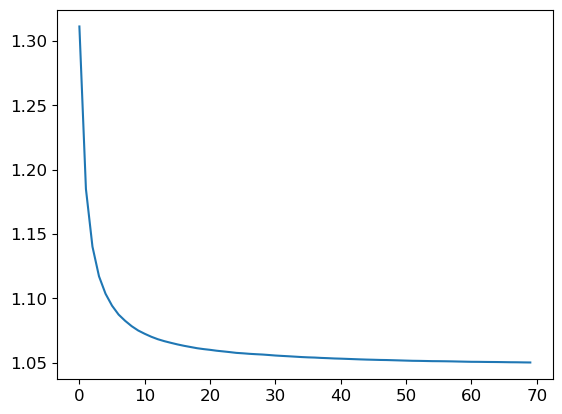

In [46]:
p = plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(70)])

# Out of bag error
There's a small diference in the error between the predictions made on the training set and the predictions made on the validation set. We can check the out of bag error to check whether this difference is due to overfitting, or whether it's due to the way that the validation set is chosen. The out of bag error measures the error for each estimator on the samples which were not used to train that estimator.

In [47]:
r_mse(m.oob_prediction_, y)

1.0515580870790575

The out of bag error is the same as the validation set error, meaning that the difference between training and validation set errors is due to the normal generalization error.

# Model interpretation

In [48]:
preds.shape

(70, 240000)

Now we have a prediction for every tree and every row in the validation set (70 trees and 240,000 rows). Using this, we can get the standard deviation of the predictions over all the trees, for each row. 

In [49]:
preds_std = preds.std(0)
preds_std[:5]

array([0.72445859, 1.27844855, 0.82417322, 0.76324493, 0.69196196])

The confidence in predictions varies widely. This is because for some auctions, there is a low standard deviation because the trees agree. For others it is higher, because the trees don't agree. This information would be useful in a production setting, for example, if the insurance company was deciding what premium to charge a customer, a low confidence prediction might cause them to look more closely at the customer before providing a quote. 

# Feature importance
It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [50]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

The feature importances of our model show that the most important features are annual income, credit score, and health score. The column 'id' should be investigated further - id is just a one to one mapping of the row index, and this shouldn't be a predictor for the insurance premium - it could be a source of data leakage, or an indication that we need to split the validation set differently in case there is some correlation between the order of the rows and the premium amount. One possible way to fix this is to shuffle and re-index the dataframe before taking the validation split. 

In [51]:
fi = rf_feature_importance(m, xs)
fi[:20]

,cols,imp
26,Annual Income,0.108201
31,Credit Score,0.103677
28,Health Score,0.088151
24,id,0.074412
39,Policy Start Elapsed,0.067989
25,Age,0.054456
38,Policy Start Dayofyear,0.048033
36,Policy Start Day,0.046984
30,Vehicle Age,0.044623
32,Insurance Duration,0.032320


In [52]:
df['id'][:5]

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

A plot of the feature importances shows the relative importances more clearly. 

<Axes: ylabel='cols'>

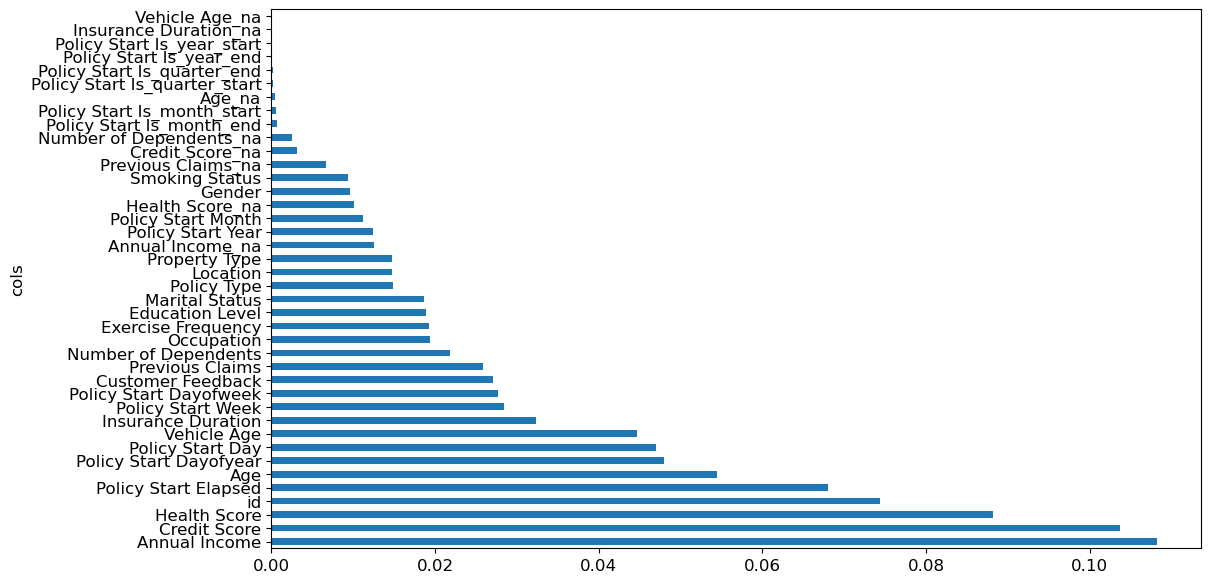

In [53]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:40])

Another possible reason for id being a predictor of premium amount is that the data might be ordered by the time since the policy was taken out- in which case the earlier ids would correlate strongly with the Policy Start Elapsed column. We can check this theory when we investigate redundant features using clustering later on. 

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing low importance features

It seems likely we could just use a subset of the columns by removing the variables of low importance and still get good results. Let's just try keeping those with a feature importance greater than 0.005.

In [54]:
to_keep = fi[fi.imp>0.03].cols
len(to_keep)

10

We can retrain the model with just this subset of important features

In [55]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)

And here's the result with only 10 columns. The error is slightly higher - a difference of 0.017 - not by much considering we dropped 24 of the 34 columns in the dataset. Training and validation set errors with all 34 columns for reference: (0.945200832139704, 1.0493446526141565)

In [56]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.9682381580511055, 1.067670332095297)

Since this is entered into a kaggle competition, we'll squeeze out every last bit of performance we can. 34 columns is already manageable too, so theres not that much to gain by dropping columns.

In [57]:
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y), len(to_keep)

(0.9456035425985689, 1.0495709446069124, 29)

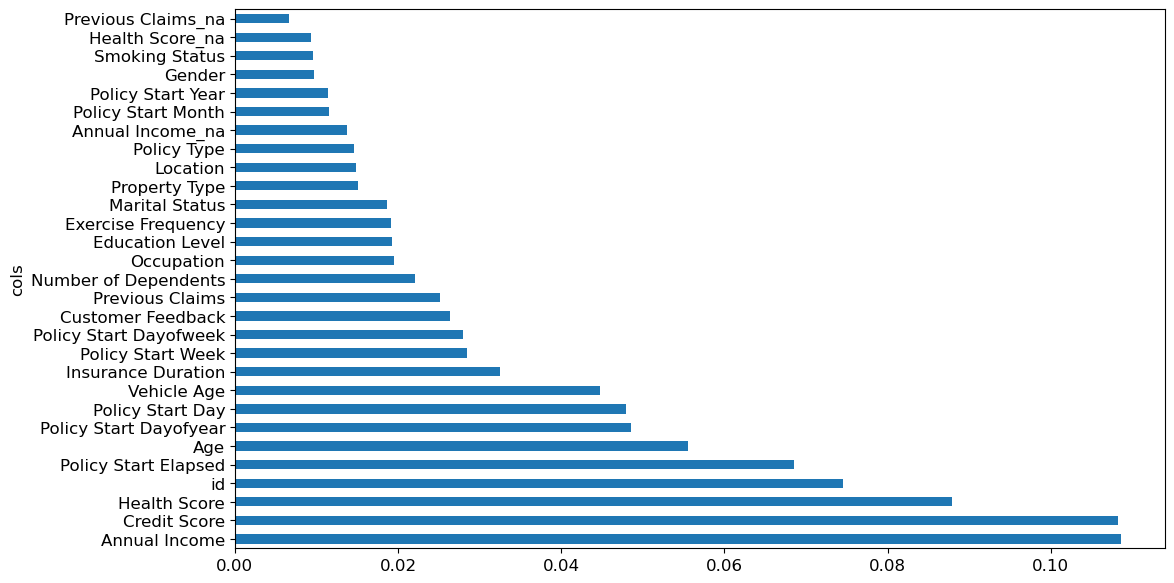

In [58]:
plot_fi(rf_feature_importance(m, xs_imp));

### Removing redundant features

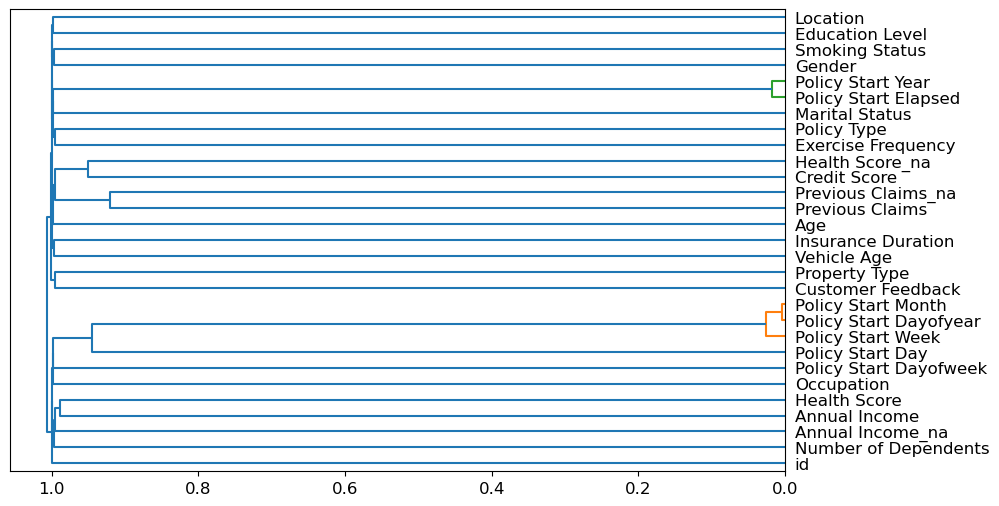

In [59]:
cluster_columns(xs_imp)

The most closely correlated features are the ones which were merged together early - far from the root of the plot. Policy Start Elapsed and Policy Start Year seem to be the same feature, as do Policy Start Month, Policy Start Dayofyear and Policy Start Day. 

Let's try removing some of these closely correlated features. We'll make a function to quickly train a random forest and return the OOB score by using fewer `max samples` and higher `min_samples_leaf`. The OOB score is the same as R^2 in statistics, where 1.0 is a perfect model and 0.0 represents a random model. 

In [60]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline

In [61]:
get_oob(xs_imp)

0.0808873664528722

Now try removing the potentially redundant features one at a time. We also noticed that id was a curious feature, so we'll try to remove that too. And just to show that this technique works, we'll try removing Health Score which is a relatively important feature.

In [62]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in ('Policy Start Elapsed', 'Policy Start Year', 'Policy Start Month', 'Policy Start Dayofyear', 'Policy Start Day', 'id', 'Health Score')}

{'Policy Start Elapsed': 0.08090314303274648,
 'Policy Start Year': 0.08102939644409035,
 'Policy Start Month': 0.08080426557153542,
 'Policy Start Dayofyear': 0.08068183946105922,
 'Policy Start Day': 0.08105194590971565,
 'id': 0.08136994865946834,
 'Health Score': 0.06938677065103305}

Dropping the id column actually improves the model. 
Let's try dropping 'Policy Start Dayofyear' and 'Policy Start Day' and 'id' together

In [63]:
to_drop = ['Policy Start Dayofyear', 'Policy Start Day', 'id']
get_oob(xs_imp.drop(to_drop, axis=1))

0.08196021477300897

It looks as though we can do without those columns. 

Let's create dataframes without those fields and save them. 

In [64]:
xs_final = xs_imp.drop(to_drop, axis='columns')
valid_xs_final = valid_xs_imp.drop(to_drop, axis='columns')

In [65]:
xs_final.columns

Index(['Annual Income', 'Credit Score', 'Health Score', 'Policy Start Elapsed',
       'Age', 'Vehicle Age', 'Insurance Duration', 'Policy Start Week',
       'Policy Start Dayofweek', 'Customer Feedback', 'Previous Claims',
       'Number of Dependents', 'Occupation', 'Exercise Frequency',
       'Education Level', 'Marital Status', 'Policy Type', 'Location',
       'Property Type', 'Annual Income_na', 'Policy Start Year',
       'Policy Start Month', 'Health Score_na', 'Gender', 'Smoking Status',
       'Previous Claims_na'],
      dtype='object')

### Checkpoint 2

In [66]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

## Checkpoint 2
# xs_final = load_pickle(path/'xs_final.pkl')
# valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

We can check the RMSE again to confirm that the accuracy hasn't changed too much

In [67]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.948573202959664, 1.049657122485026)

We've simplified our model by removing unimportant and redundant features and keeping the most important variables, without losing much accuracy. Let's see how those variables affect our predictions using partial dependence plots. 

# Partial dependence

We know that the most important features are annual income, credit score and health score. These are all continuous variables. We'd like to understand the relationship between these variables and the premium amount. Let's check the distribution of these variables and the counts of any continuous variables.

In [68]:
to.classes

{'Gender': ['#na#', 'Female', 'Male'],
 'Marital Status': ['#na#', 'Divorced', 'Married', 'Single'],
 'Education Level': ['#na#', 'High School', "Bachelor's", "Master's", 'PhD'],
 'Occupation': ['#na#', 'Employed', 'Self-Employed', 'Unemployed'],
 'Location': ['#na#', 'Rural', 'Suburban', 'Urban'],
 'Policy Type': ['#na#', 'Basic', 'Comprehensive', 'Premium'],
 'Customer Feedback': ['#na#', 'Average', 'Good', 'Poor'],
 'Smoking Status': ['#na#', 'No', 'Yes'],
 'Exercise Frequency': ['#na#', 'Daily', 'Monthly', 'Rarely', 'Weekly'],
 'Property Type': ['#na#', 'Apartment', 'Condo', 'House'],
 'Policy Start Is_month_end': ['#na#', False, True],
 'Policy Start Is_month_start': ['#na#', False, True],
 'Policy Start Is_quarter_end': ['#na#', False, True],
 'Policy Start Is_quarter_start': ['#na#', False, True],
 'Policy Start Is_year_end': ['#na#', False, True],
 'Policy Start Is_year_start': ['#na#', False, True],
 'Age_na': ['#na#', False, True],
 'Annual Income_na': ['#na#', False, True],


The categorical features aren't so important in this model, but we can still check the distribution of the value levels for each category if needed:

['#na#', 'Average', 'Good', 'Poor']


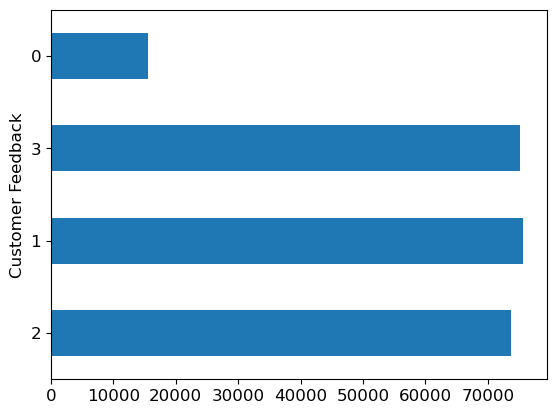

In [69]:
category = 'Customer Feedback'
p = valid_xs_final[category].value_counts(sort=False, dropna=False).plot.barh()    

c = to.classes[category]
print(c)

### Check the continuous variables

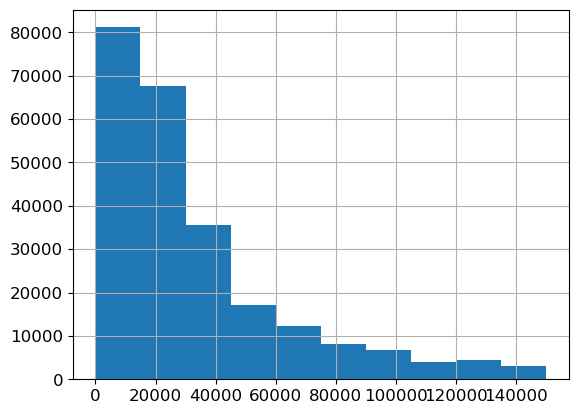

In [70]:
ax = valid_xs_final['Annual Income'].hist()

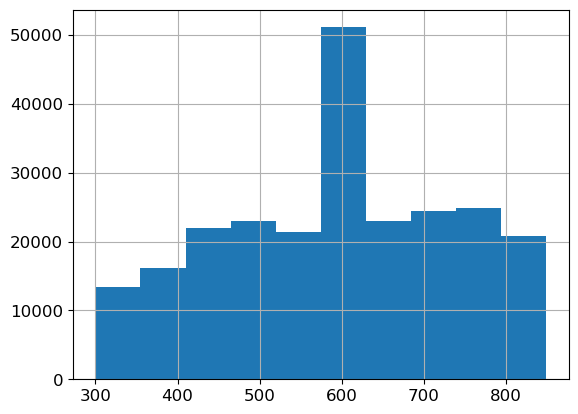

In [71]:
ax = valid_xs_final['Credit Score'].hist()

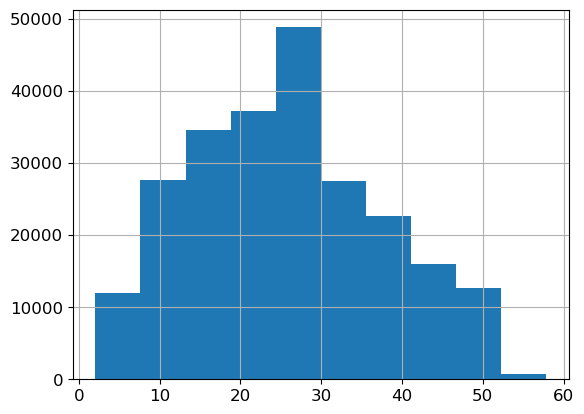

In [72]:
ax = valid_xs_final['Health Score'].hist()

There's nothing too unusual about these distributions, except that the credit score has a large spike around 600. This could be the default credit score people start out with, or the average credit score for people who had the credit score missing. It's worth keeping in mind the possibility of data leakage, in case for example the credit score only gets updated with a value after somebody has made a claim, or a similar second order effect. 

# Partial Dependence Plots

Partial dependence says _'all other things being equal, what would happen to the predictions if we only varied feature x'_

In [73]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

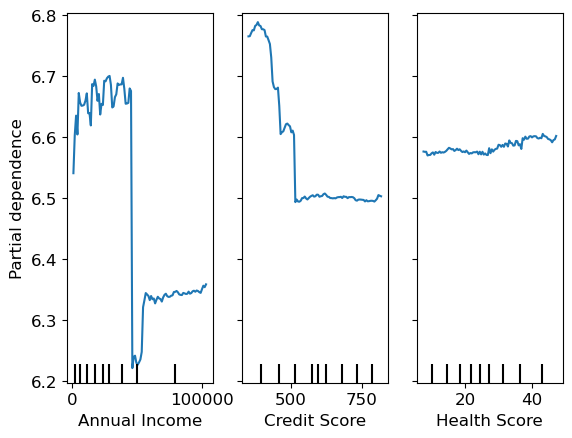

In [264]:
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ["Annual Income", "Credit Score", "Health Score"])

# Tree interpreter / Waterfall plots
- For predicting with a particular row of data, what were the most important factors, and how did these influence the prediction?



In [75]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Choose the first 5 rows from the dataset

In [244]:
row = valid_xs_final.iloc[:5]

In [245]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

__Prediction__ is the prediction the random forest makes. __Bias__ is the prediction based on taking the mean of the dependent variable - or the average insurance premium for all of the training data point. __Contributions__ is the total change in prediction due to each of the independent variables.

Look at one row from these predictions

In [246]:
idx = 2
prediction[idx], bias[idx], contributions[idx].sum()

(array([6.48358116]), 6.594196428003789, -0.11061527134489255)

# Convert the contribution / error values back up to the original scale
One important thing to remember, is that since these values (and the errors, contributions, biases and the final predictions) are on a logarithmic scale, the contribution change should be measured relative to the bias - not relative to zero. For example, if we just take np.expm1(0.11) we might be led to think that the model only predicted a change of 10 cents. To get an idea of how much the final price was affected, we should be calculating the change relative to the bias:
```python
np.expm1(bias) - np.expm1(bias + contributions)
```

In [250]:
np.expm1(bias[idx]) - np.expm1(bias[idx] + contributions[idx].sum())

76.53142498631871

For this row, we can see the total contribution changes which each column makes to the prediction, measured relative to the baseline bias - or average premium over the whole dataset.

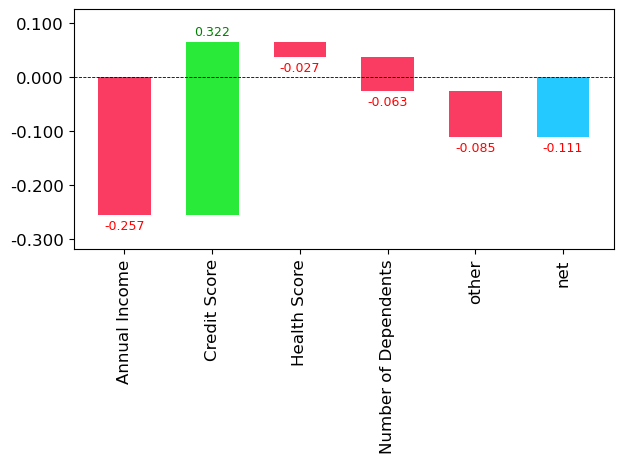

In [252]:
waterfall(valid_xs_final.columns, contributions[idx], threshold=0.08, 
          rotation_value=90,formatting='{:,.3f}');

In [148]:
feature = "Annual Income"
pd.DataFrame(valid_xs_final.iloc[2]).T[feature], valid_xs_final[feature].mean()

(893682    51164.0
 Name: Annual Income, dtype: float32,
 32426.771)

In [256]:
np.expm1(bias[idx]) - np.expm1(bias[idx] + 0.257)

-214.16950103598538

Having an annual income of 20k above the mean value of 32k increases the premium by $214.

For this example, we can see that Annual Income reduced the premium amount by 0.257 but the relatively low credit score increases the premium back up by 0.322. The real world change here is:

In [254]:
np.expm1(bias[idx]) - np.expm1(bias[idx] + 0.322)

-277.6355089663125

# Let's find the largest possible contribution from income

In [257]:
# find the row with the maximum Annual Income from valid_xs_final
max_income = pd.DataFrame(valid_xs_final.loc[valid_xs_final['Annual Income'].idxmax()]).T
max_income

,Annual Income,Credit Score,Health Score,Policy Start Elapsed,...,Health Score_na,Gender,Smoking Status,Previous Claims_na
810763,149996.0,637.0,28.988052,1.715354e+09,...,1.0,2.0,2.0,1.0


In [258]:
prediction,bias,contributions = treeinterpreter.predict(m, max_income.values)
prediction, bias, contributions.sum()

(array([[5.27780681]]), array([6.59419643]), -1.3163896198702738)

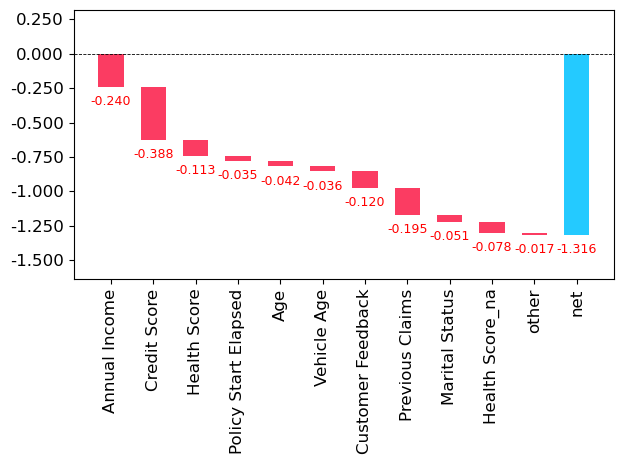

In [259]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=90,formatting='{:,.3f}');

In [ ]:
np.expm1(bias) - np.expm1(prediction)

array([[534.90169654]])

The highest earner in the dataset gets a reduction in premium of $535

 One interesting observation here, is that _income seems to be a proxy for a bunch of other predictive variables._

# Making a prediction
To make predictions on the test set, we need to load the test set into Pandas then preprocess it in the same way as the test set was processed. 


In [80]:
# Test df
tdf = pd.read_csv('test.csv')

In [81]:
tdf.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

In [82]:
tdf["Education Level"] = tdf['Education Level'].astype('category')
tdf["Education Level"] = tdf['Education Level'].cat.set_categories(edu_levels, ordered=True)

tdf = add_datepart(tdf, 'Policy Start Date')

# Test tabular object
tto = TabularPandas(tdf, procs, cat, cont)

# m.predict(df_test)

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [83]:
tto.show(3)

,Gender,Marital Status,Education Level,Occupation,Location,Policy Type,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Start Is_month_end,Policy Start Is_month_start,Policy Start Is_quarter_end,Policy Start Is_quarter_start,Policy Start Is_year_end,Policy Start Is_year_start,Age_na,Annual Income_na,Number of Dependents_na,Health Score_na,Previous Claims_na,Vehicle Age_na,Credit Score_na,Insurance Duration_na,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Year,Policy Start Month,Policy Start Week,Policy Start Day,Policy Start Dayofweek,Policy Start Dayofyear,Policy Start Elapsed
0,Female,#na#,Bachelor's,Self-Employed,Rural,Basic,Poor,Yes,Weekly,House,False,False,False,False,False,False,False,False,False,False,True,False,True,False,1200000,28.0,2310.0,4.0,7.657981,1.0,19.0,595.0,1.0,2023,6,22,4,6,155,1.685892e+09
1,Female,Married,Master's,Self-Employed,Suburban,Premium,Good,Yes,Rarely,Apartment,False,False,False,False,False,False,False,False,False,False,True,False,False,False,1200001,31.0,126031.0,2.0,13.381379,1.0,14.0,372.0,8.0,2024,4,17,22,0,113,1.713799e+09
2,Female,Divorced,PhD,Unemployed,Urban,Comprehensive,Average,Yes,Monthly,Condo,False,False,False,False,False,False,False,False,False,False,True,False,False,False,1200002,47.0,17092.0,0.0,24.354527,1.0,16.0,819.0,9.0,2023,4,14,5,2,95,1.680708e+09


In [84]:
# Test xs
txs = tto.xs

In [85]:
to_keep

26           Annual Income
31            Credit Score
28            Health Score
24                      id
39    Policy Start Elapsed
              ...         
34      Policy Start Month
19         Health Score_na
0                   Gender
7           Smoking Status
20      Previous Claims_na
Name: cols, Length: 29, dtype: object

In [86]:
txs_imp = txs[to_keep]


In [87]:
txs_final = txs_imp.drop(to_drop, axis='columns')

In [88]:
submission = m.predict(txs_final)

In [399]:
# write submission to a csv file with headers id,Premium Amount
submission_df = pd.DataFrame({'id': tdf['id'], 'Premium Amount': np.expm1(submission)})


In [90]:
submission_df.to_csv('submission.csv', index=False)

In [91]:
submission_df.head()

,id,Premium Amount
0,1200000,801.737461
1,1200001,853.567610
2,1200002,743.969326
3,1200003,814.828909
4,1200004,653.490348


# Using this approach resulted in a model which placed 818/2392 on the Kaggle private leaderboard. 
That's 35th percentile. In general if you place above the 50th percentile on Kaggle you've done pretty well and have a model which would perform well in production. This is because the competitive nature of the Kaggle competitions incentivise entries with more and more marginal gains. 

# Improving on the Random Forest.

### The extrapolation problem 
TL;DR: Random forests can't extrapolate beyond the range of the training data. 

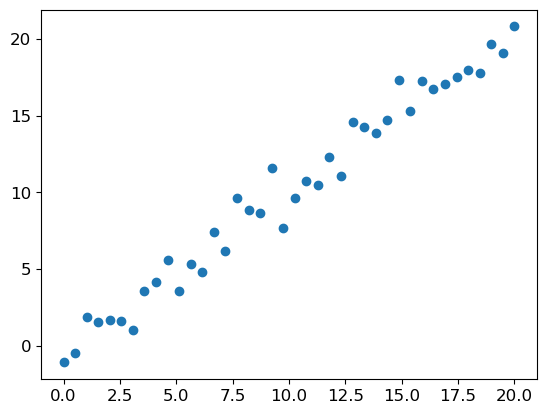

In [274]:
# Synthetic linear data with noise
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [275]:
x_lin.shape

torch.Size([40])

sklearn expects a matrix of independent variables, not a single vector. We can use unsqueeze(1) or slice the array to a tensor with the special value None:

In [276]:
xs_lin = x_lin[:, None]
xs_lin.shape

torch.Size([40, 1])

Let's train a random forest on the first 30 data points and leave the final 10 out.

In [277]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

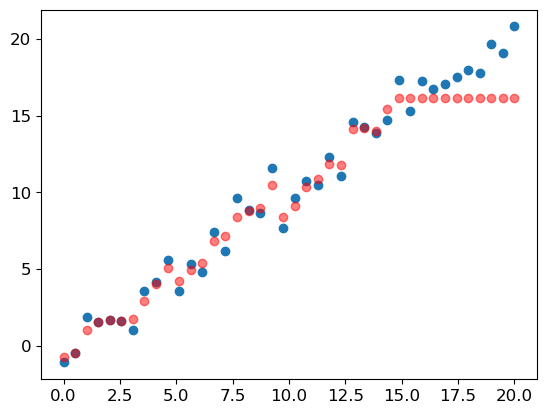

In [283]:
plt.scatter(x_lin, y_lin)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

This demonstration shows how random forests can't extrapolate beyond the range of the training data. If there's a time series component, such as inflation, or just some new ranges which didn't occur in the training set, then the random forest will not be able to predict accurately for these cases and the predictions will be systematically too low or too high. 

# Finding out-of-domain data
To find out whether the training set and the validation set are distributed in the same way, we can use a cool trick and train a random forest to predict whether a row of data is from the training set or the validation set!

In [286]:
# df out-of-domain
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))
m = rf(df_dom, is_valid)
rf_feature_importance(m, df_dom)[:12]

,cols,imp
0,Annual Income,0.114124
2,Health Score,0.113457
1,Credit Score,0.098175
3,Policy Start Elapsed,0.094904
4,Age,0.076022
5,Vehicle Age,0.060459
7,Policy Start Week,0.058718
6,Insurance Duration,0.042909
8,Policy Start Dayofweek,0.037940
11,Number of Dependents,0.029121


Since these columns are all predictors of whether a row is from the training set or the validation set, they are the features which contain the highest differences in distribution. In our case, we just took a random sample of the data, so there's not much we can do to help here. But in cases where there is a temporal or other necessary split, it would be helpful to remove those columns for which there is a large difference in distribution, and which don't contribute too much to the accuracy of the model.

In [287]:
m = rf (xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ("Annual Income", "Health Score", "Credit Score", "Policy Start Elapsed", "Age", "Vehicle Age", "Policy Start Week"):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 1.0491192462331866
Annual Income 1.0870869717827008
Health Score 1.0560707798218818
Credit Score 1.080604905922193
Policy Start Elapsed 1.0488449446368762
Age 1.049118477547121
Vehicle Age 1.0491874480475374
Policy Start Week 1.0488886655687548


It looks as though we should be able to remove the columns 'Policy Start Week', 'Policy Start Elapsed', and 'Age' without losing too much accuracy.

In [288]:
bias_vars = ['Policy Start Week', 'Policy Start Elapsed', 'Age']
xs_final_bias = xs_final.drop(bias_vars, axis=1)
valid_xs_bias = valid_xs_final.drop(bias_vars, axis=1)

m = rf(xs_final_bias, y)
m_rmse(m, valid_xs_bias, valid_y)

1.0488895553861335

# Removing the columns which were biased

Retraining the model without those bias columns gives slightly better accuracy, but more importantly it should make the model more resillient, easier to maintain and understand.

Again, this would be especially important for datasets where the training and validation sets were split by time or some other necessary split..

This approach can be used on any dataset to detect subtle domain shift issues which otherwise might not be noticed.

# Removing old data
Sometimes the older data contains relationships which are no longer valid. Removing rows from before a certain year can often improve performance, and shows that you shouldn't always use all of the available data. Sometimes a well chosen subset is better. 

# Neural Networks

In [319]:
df_nn = pd.read_csv(path/"train.csv", low_memory=False)
df_nn["Education Level"] = df_nn['Education Level'].astype('category')
df_nn["Education Level"] = df_nn['Education Level'].cat.set_categories(edu_levels, ordered=True)
df_nn[dep_var] = np.log1p(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'Policy Start Date')

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [320]:
drop = ['Annual Income_na', 'Health Score_na', 'Previous Claims_na']

In [321]:
df_nn_final = df_nn[list(xs_final_bias.drop(columns=drop).columns) + [dep_var]]

In [322]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [323]:
cont_nn, cat_nn

(['Annual Income',
  'Credit Score',
  'Health Score',
  'Vehicle Age',
  'Insurance Duration',
  'Previous Claims',
  'Number of Dependents'],
 ['Policy Start Dayofweek',
  'Customer Feedback',
  'Occupation',
  'Exercise Frequency',
  'Education Level',
  'Marital Status',
  'Policy Type',
  'Location',
  'Property Type',
  'Policy Start Year',
  'Policy Start Month',
  'Gender',
  'Smoking Status'])

In [324]:
cont_nn.append('Policy Start Year')
cont_nn.remove('Policy Start Year')

In [325]:
df_nn_final[cat_nn].nunique()

Policy Start Dayofweek     7
Customer Feedback          3
Occupation                 3
Exercise Frequency         4
Education Level            4
Marital Status             3
Policy Type                3
Location                   3
Property Type              3
Policy Start Year          6
Policy Start Month        12
Gender                     2
Smoking Status             2
dtype: int64

There aren't many high cardinality categorical variables in this dataset.

In [326]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [327]:
dls = to_nn.dataloaders(1024)

In [329]:
y = to_nn.train.y
y.min(), y.max()

(3.0445225, 8.516793)

In [332]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log1p(pred), torch.log1p(actual)))
custom_rmsle_loss = RMSLELoss()


SuggestedLRs(valley=0.0008317637839354575)

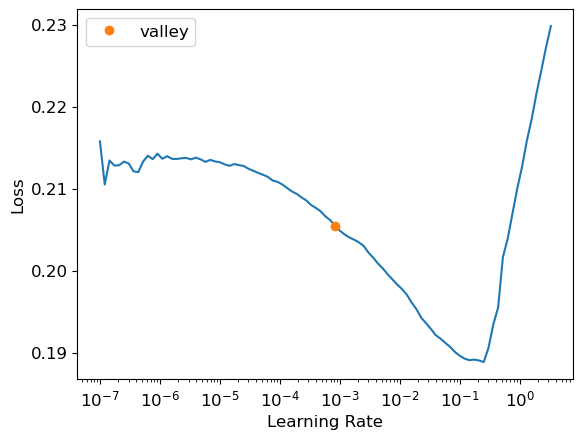

In [333]:
from fastai.tabular.all import *
learn = tabular_learner(dls, y_range=(3, 9),layers=[200,100], n_out=1, loss_func=custom_rmsle_loss)
learn.lr_find()

In [334]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.163907,0.166388,00:25
1,0.162703,0.165677,00:24
2,0.163396,0.163910,00:24
3,0.163030,0.163344,00:24
4,0.161707,0.163257,00:24


In [335]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

1.087911609056907

In [336]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(8, 5)
    (1-2): 2 x Embedding(4, 3)
    (3-4): 2 x Embedding(5, 4)
    (5-8): 4 x Embedding(4, 3)
    (9): Embedding(7, 5)
    (10): Embedding(13, 7)
    (11-19): 9 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=77, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=3, high=9)
  )
)

SuggestedLRs(valley=0.0002290867705596611)

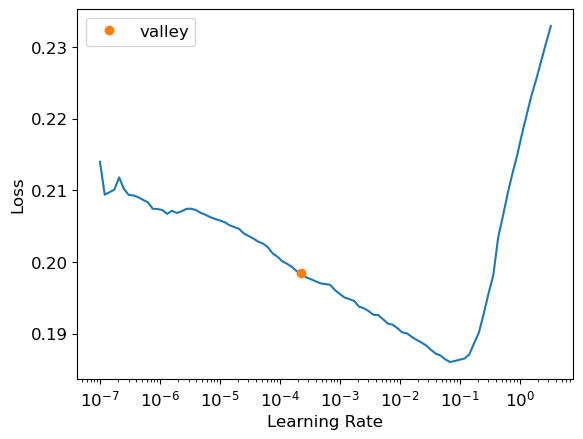

In [341]:
learn = tabular_learner(dls, y_range=(3,9), layers=[500,250], n_out=1, loss_func=custom_rmsle_loss)
learn.lr_find()

In [342]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.162351,0.164317,00:24
1,0.159144,0.160406,00:24
2,0.159710,0.159286,00:24
3,0.158863,0.158587,00:25
4,0.158756,0.158806,00:24
5,0.158931,0.158449,00:24
6,0.157816,0.158194,00:24
7,0.158522,0.158232,00:24
8,0.157851,0.157965,00:24
9,0.157388,0.158006,00:24


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

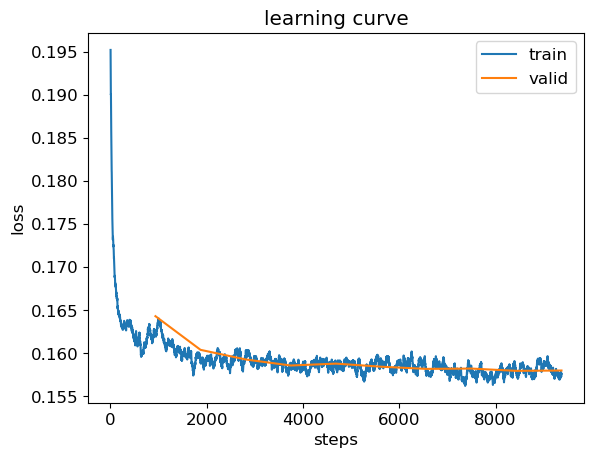

In [344]:
learn.recorder.plot_loss()

In [345]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

1.0521938089714644

1.04888 is the score to beat from the random forest. One more attempt - the training curve is pretty noisy. Let's reduce the learning rate a bit to see if we can get a better result.

In [346]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,0.158851,0.158034,00:25
1,0.157593,0.157959,00:25
2,0.157541,0.157977,00:24
3,0.158346,0.158004,00:25
4,0.157386,0.157996,00:25


In [347]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

1.0521918829386747

The neural network didn't work as well as the random forest for this dataset. It may perform better on other datasets where extrapolation is needed.

In [350]:
learn.save('nn')

Path('models/nn.pth')

# Ensembling

In [352]:
rf_preds = m.predict(valid_xs_bias)
preds, rf_preds

(tensor([[6.6099],
         [6.1475],
         [6.5474],
         ...,
         [6.5842],
         [6.3467],
         [6.6124]]),
 array([6.55583468, 6.42468671, 6.73674726, ..., 6.604843  , 6.66766988, 6.63748909]))

The predictions from the neural net and from the random forest are different data types. PyTorch gives us a rank 2 tensor, whereas sklearn gives us a vector, or a rank 1 array. 

In [353]:
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [354]:
r_mse(ens_preds, valid_y)

1.0475928203186846

# Ensembling the two models together gives a better result than either model achieved on its own.

# Submit the ensemble preds to Kaggle

In [ ]:
rf_submission = m.predict(txs_final.drop(bias_vars, axis=1))

### Process the test set for NN
- Load the test set, 
- scale the data and drop some columns, 
- Normalize the data since it's going into a neural network. 

In [365]:
test_nn = pd.read_csv(path/"test.csv", low_memory=False)
test_nn["Education Level"] = test_nn['Education Level'].astype('category')
test_nn["Education Level"] = test_nn['Education Level'].cat.set_categories(edu_levels, ordered=True)
test_nn[dep_var] = np.log1p(df_nn[dep_var])
test_nn = add_datepart(test_nn, 'Policy Start Date')

/Users/mikeg/miniforge3/envs/fastai/lib/python3.10/site-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [366]:
test_nn_final = test_nn[list(xs_final_bias.drop(columns=drop).columns)]

In [382]:
procs_test_nn = [Categorify, FillMissing, Normalize]
to_test_nn = TabularPandas(test_nn_final, procs_nn, cat_nn, cont_nn)
type(to_test_nn)

fastai.tabular.core.TabularPandas

In [383]:
dls.test_dl(to_test_nn.items)

Make predictions on the test set using the neural network

In [393]:
nn_test_preds, _ = learn.get_preds(dl=dls.test_dl(to_test_nn.items))
nn_test_preds[:5]

tensor([[6.6865],
        [6.7124],
        [6.7418],
        [6.6907],
        [6.7238]])

In [394]:
ensemble_submission = (to_np(nn_test_preds.squeeze()) + rf_submission) / 2

In [401]:
# write submission to a csv file with headers id,Premium Amount
submission_df = pd.DataFrame({'id': test_nn['id'], 'Premium Amount': np.expm1(ensemble_submission)})

In [403]:
submission_df.to_csv('ensemble_submission.csv', index=False)

In [404]:
submission_df.head()

,id,Premium Amount
0,1200000,722.564827
1,1200001,796.460073
2,1200002,733.961725
3,1200003,838.133342
4,1200004,826.356850
